In [9]:
import pandas as pd
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [2]:
books_data_raw = pd.read_csv('data/Books_rating.csv')
books_data_raw

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...
...,...,...,...,...,...,...,...,...,...,...
2999995,B000NSLVCU,The Idea of History,NaN,NaN,NaN,14/19,4.0,937612800,Difficult,"This is an extremely difficult book to digest,..."
2999996,B000NSLVCU,The Idea of History,NaN,A1SMUB9ASL5L9Y,jafrank,1/1,4.0,1331683200,Quite good and ahead of its time occasionally,This is pretty interesting. Collingwood seems ...
2999997,B000NSLVCU,The Idea of History,NaN,A2AQMEKZKK5EE4,"L. L. Poulos ""Muslim Mom""",0/0,4.0,1180224000,Easier reads of those not well versed in histo...,"This is a good book but very esoteric. ""What i..."
2999998,B000NSLVCU,The Idea of History,NaN,A18SQGYBKS852K,"Julia A. Klein ""knitting rat""",1/11,5.0,1163030400,"Yes, it is cheaper than the University Bookstore","My daughter, a freshman at Indiana University,..."


In [3]:
books_data = books_data_raw[['review/score', 'review/text']].copy()
books_data.rename(columns={'review/score': 'score', 'review/text': 'text'}, inplace=True)

In [4]:
# Remove rows with null values.
books_data = books_data.dropna()
len(books_data)

2999992

<AxesSubplot: xlabel='score', ylabel='count'>

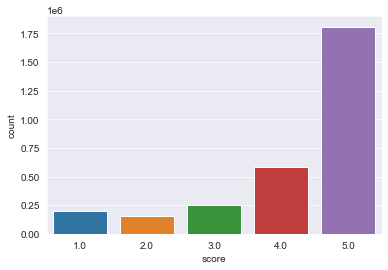

In [5]:
sns.countplot(x='score', data=books_data)

In [ ]:
X = books_data.text
y = books_data.score
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1
X = pad_sequences(X, padding='post')

In [8]:
under_sampler = RandomUnderSampler(random_state=42)
X, y = under_sampler.fit_resample([text for text in books_data.text], books_data.score)

MemoryError: Unable to allocate 364. GiB for an array with shape (2999992, 1) and data type <U32576